## This notebook has the goal of making the Mixture of Factor Analyzers (MFA) model, along with benchmark models

The models are to be saved to a models-folder in the project. 
As a benchmark-model, PCA is to be used. Further benchmark-models might be added. 
Trainingtime for each model should be noted.

In [10]:
import torch
import glob
from hypso import Hypso
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from MFA import MFA
import numpy as np
import os

### fetching training-data
The training-data consists of a subsample of pixels taken from vastly different geographical places. The image was choosen to deliberatly include both water and land pixels for there to naturally be more classes for the model to describe. 

in "01_model_testing.ipynb", the trained models will be tested on new pixels.

In [12]:
# can be 'l1a', 'l1b', or 'l1d'
data_product = 'l1b'

In [14]:
# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

data_dir = glob.glob(f'../data/training_{data_product}/*.nc')
print(f"Found {len(data_dir)} files.")

Using device: cpu
Found 44 files.


In [4]:
import torch.nn.functional as F

def extract_spatial_spectral_features(hsi_cube_np, window_size=3):
    """
    Expands an (H, W, B) hyperspectral cube to (H, W, 3*B) by appending 
    local neighborhood mean and standard deviation.
    """
    # Reshape to (Batch, Channels, Height, Width) for PyTorch 2D operations
    cube_t = torch.from_numpy(hsi_cube_np).float().unsqueeze(0).permute(0, 3, 1, 2)
    
    pad = window_size // 2
    
    # 1. Local Mean
    avg_pool = F.avg_pool2d(cube_t, kernel_size=window_size, stride=1, padding=pad)
    
    # 2. Local Standard Deviation
    cube_sq = cube_t ** 2
    avg_sq_pool = F.avg_pool2d(cube_sq, kernel_size=window_size, stride=1, padding=pad)
    var_pool = torch.clamp(avg_sq_pool - avg_pool ** 2, min=0.0)
    std_pool = torch.sqrt(var_pool)
    
    # 3. Concatenate (Original, Mean, Std)
    augmented_cube = torch.cat([cube_t, avg_pool, std_pool], dim=1)
    
    # Return to numpy (H, W, 3*B)
    return augmented_cube.squeeze(0).permute(1, 2, 0).numpy()

In [5]:
target_total_samples = 40000
samples_per_file = target_total_samples // len(data_dir) 
sampled_data_list = []

print(f"Aiming to extract ~{samples_per_file} pixels per file.")

for file in data_dir:
    # Load Data
    try:
        satobj = Hypso(file) 
        if satobj is None: continue
        
        # Load and reshape
        match data_product:
            case 'l1a':
                data = satobj.l1a_cube.values.astype(np.float32)
            case 'l1b':
                data = satobj.l1b_cube.values.astype(np.float32)
            case 'l1d':
                data = satobj.l1d_cube.values.astype(np.float32)
            case _:
                raise ValueError(f"Unknown data product: {data_product}")
            
        data_aug = extract_spatial_spectral_features(data, window_size=3)
        
        h, w, b = data_aug.shape
        data_2d = data_aug.reshape(-1, b) # Shape: (Total_Pixels_In_Image, 120)
        
        # Random Subsampling 
        total_pixels_in_image = data_2d.shape[0]
        
        # Determine how many to take (don't take more than exists)
        n_to_take = min(samples_per_file, total_pixels_in_image)

        # Removing saturated pixels
        highest_pixel_value = np.max(data_2d)
        print(f"Highest pixel value in file {os.path.basename(file)}: {highest_pixel_value}")
        valid_pixel_mask = np.all(data_2d < highest_pixel_value, axis=1)
        data_2d = data_2d[valid_pixel_mask]
        print(f"Number of removed pixels: {total_pixels_in_image - data_2d.shape[0]}")
        total_pixels_in_image = data_2d.shape[0]
        n_to_take = min(n_to_take, total_pixels_in_image)
        
        # Generate random indices
        rng = np.random.default_rng()
        indices = rng.choice(total_pixels_in_image, size=n_to_take, replace=False)
        
        # Grab the random pixels and add to list
        sampled_pixel_subset = data_2d[indices, :]
        sampled_data_list.append(sampled_pixel_subset)
        
        print(f"File: {os.path.basename(file)} | Extracted {n_to_take} pixels.")

    except Exception as e:
        print(f"Error processing {file}: {e}")

# Final Concatenation
if sampled_data_list:
    data = np.concatenate(sampled_data_list, axis=0)
    #Convert to torch tensor
    data = torch.from_numpy(data).float().to(device)
    print("-" * 30)
    print(f"Final Analysis Dataset Shape: {data.shape}")
else:
    print("No data loaded.")

Aiming to extract ~909 pixels per file.
Highest pixel value in file aeronetgalata_2025-01-02T08-18-16Z-l1b.nc: 125.7120361328125
Number of removed pixels: 1
File: aeronetgalata_2025-01-02T08-18-16Z-l1b.nc | Extracted 909 pixels.
Highest pixel value in file algeria_2022-10-29T09-44-03Z-l1b.nc: 145.38905334472656
Number of removed pixels: 1
File: algeria_2022-10-29T09-44-03Z-l1b.nc | Extracted 909 pixels.
Highest pixel value in file amazonia_2024-09-21T13-12-47Z-l1b.nc: 355.76715087890625
Number of removed pixels: 1
File: amazonia_2024-09-21T13-12-47Z-l1b.nc | Extracted 909 pixels.
Highest pixel value in file annapolis_2025-08-04T15-25-40Z-l1b.nc: 188.49148559570312
Number of removed pixels: 1
File: annapolis_2025-08-04T15-25-40Z-l1b.nc | Extracted 909 pixels.
Highest pixel value in file antarctica_2022-11-20T08-44-35Z-l1b.nc: 306.9892883300781
Number of removed pixels: 1
File: antarctica_2022-11-20T08-44-35Z-l1b.nc | Extracted 909 pixels.
Highest pixel value in file barfire_2025-08-04T0

## Look for outliers or dead pixels

Iterating over the pixels to see if any are all zero or all max

In [6]:
# 1. Create a boolean mask where True indicates a dead pixel
# We check if ALL values along the last dimension (bands) are 0
dead_pixel_mask = (data == 0).all(dim=-1)

# 2. Get the indices/coordinates of the dead pixels
dead_pixel_indices = torch.nonzero(dead_pixel_mask)

# Check how many dead pixels were found
print(f"Number of dead pixels: {dead_pixel_indices.shape[0]}")

Number of dead pixels: 0


## Making the MFA Model

### Model Selection
Determining the optimal model order—specifically the number of mixture components ($K$) and the dimensionality of the latent factor space ($q$)—is a critical step to prevent overfitting. The literature emphasizes two primary methods for this selection process:
1. **The Information Criteria Approach (BIC)**

Source: McLachlan, G., & Peel, D. (2000). *Finite Mixture Models.*

This approach involves performing a grid search over potential $(K, q)$ combinations. For each combination, we calculate the Bayesian Information Criterion (BIC) and select the pair with the lowest BIC score. This metric balances goodness-of-fit with model complexity:$$\text{BIC} = -2 \ln(\mathcal{L}) + d \ln(n)$$
Where:
$\mathcal{L}$ is the maximized likelihood of the model.
$d$ is the number of free parameters.
$n$ is the number of observations.

2. **The Variational Bayesian Approach (VB)**

Source: Ghahramani, Z., & Beal, M. J. (2000). *Variational Inference for Bayesian Mixtures of Factor Analysers.*

Unlike the BIC grid search, the Variational Bayesian method treats model selection as an integral part of the optimization process itself, rather than a post-hoc comparison.
Mechanism: It places Dirichlet priors on the mixing coefficients and Automatic Relevance Determination (ARD) priors on the factor loading matrices.
Result: As the model trains, it automatically drives the coefficients of unnecessary components or factors to zero, effectively selecting the model structure in a single run.

## Choosen approach
1. Perform PCA on the entire dataset. If a single PCA model can describe >99.5% of the variance with *N* number of components, then we set *N* as the ceiling for our BIC-method. Source: Bioucas-Dias, J. M., & Nascimento, J. M. (2008). *Hyperspectral Subspace Identification.*

2. Sample a subset of the pixels 10,000 - 50,000 pixels. Source: Banfield, J. D., & Raftery, A. E. (1993). *Model-Based Gaussian and Non-Gaussian Clustering.*

3. Perform the grid search on the sampled pixels. Plot the BIC-curves. 

4. Retrain the optimal compinantion on the complete dataset.

### 1. Make PCA-model

------------------------------
Cumulative Variance for top 10 components:
 tensor([0.8960, 0.9551, 0.9793, 0.9889, 0.9927, 0.9945, 0.9960, 0.9970, 0.9976,
        0.9981])
------------------------------
Number of components to explain 99.5% variance: 7
Ceiling for q (latent factors) set to: 7
PCA model saved to 'models/pca_benchmark_l1b.pt'


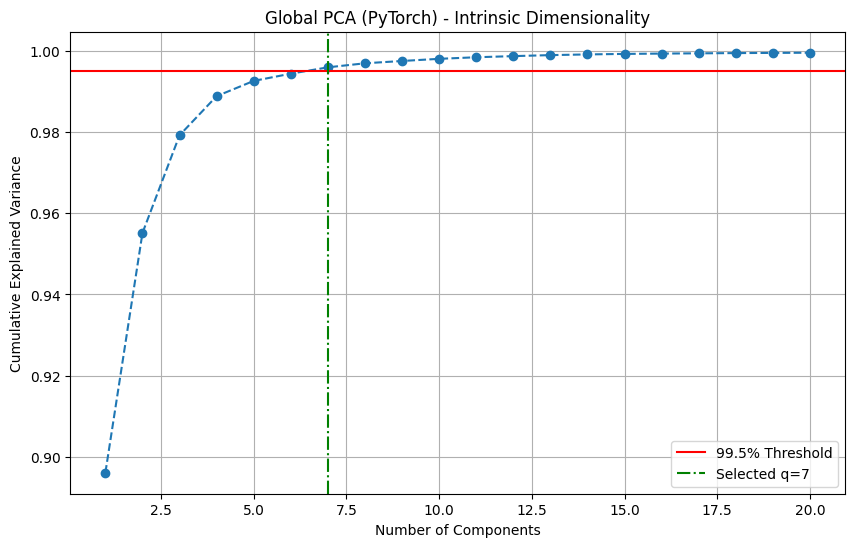

In [ ]:
# 1. Mean Centering
mean_vector = data.mean(dim=0)
X_centered = data - mean_vector

# 2. Compute Covariance Matrix
n_samples = X_centered.shape[0]
cov_matrix = (X_centered.T @ X_centered) / (n_samples - 1)

# 3. Eigendecomposition (PCA)
eigenvalues, eigenvectors = torch.linalg.eigh(cov_matrix)

# 4. Sort indices in descending order (eigh returns ascending)
sorted_indices = torch.argsort(eigenvalues, descending=True)
sorted_eigenvalues = eigenvalues[sorted_indices]
sorted_components = eigenvectors[:, sorted_indices]

# 5. Calculate Cumulative Variance
total_variance = sorted_eigenvalues.sum()
explained_variance_ratio = sorted_eigenvalues / total_variance
cum_var = torch.cumsum(explained_variance_ratio, dim=0)

# 6. Find the threshold (99.5%)
threshold = 0.995
n_components_995 = (cum_var >= threshold).nonzero(as_tuple=False)[0].item() + 1

print("-" * 30)
print(f"Cumulative Variance for top 10 components:\n {cum_var[:10]}")
print("-" * 30)
print(f"Number of components to explain {threshold*100}% variance: {n_components_995}")
print(f"Ceiling for q (latent factors) set to: {n_components_995}")

# 7. Save the PCA Model
pca_state = {
    'components': sorted_components[:, :n_components_995], # Save only needed components
    'mean': mean_vector,
    'explained_variance': sorted_eigenvalues[:n_components_995],
    'n_components_995': n_components_995
}
torch.save(pca_state, f'../models/pca_benchmark_{data_product}.pt')
print(f"PCA model saved to '../models/pca_benchmark_{data_product}.pt'")

# 8. Visual Check
# Move to CPU for plotting
cum_var_np = cum_var.cpu().numpy()
plt.figure(figsize=(10, 6))
plt.plot(range(1, 21), cum_var_np[:20], marker='o', linestyle='--')
plt.axhline(y=threshold, color='r', linestyle='-', label=f'{threshold*100}% Threshold')
plt.axvline(x=n_components_995, color='g', linestyle='-.', label=f'Selected q={n_components_995}')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Global PCA (PyTorch) - Intrinsic Dimensionality')
plt.legend()
plt.grid(True)
plt.show()

### 2. Subsample the dataset

In [8]:
# Configuration
N_SUBSET = 20000 
torch.manual_seed(42)

subset_device = device # or torch.device('cpu')

# Generate random indices
if data.shape[0] > N_SUBSET:
    # random_split or randperm is standard torch practice
    indices = torch.randperm(data.shape[0])[:N_SUBSET]
    data_subset = data[indices].to(subset_device)
    print(f"Subsampled data from {data.shape[0]} to {data_subset.shape[0]} samples.")
else:
    data_subset = data.to(subset_device)
    print("Dataset smaller than requested subset. Using full data.")

print(f"Subset shape: {data_subset.shape}")

Subsampled data from 39996 to 20000 samples.
Subset shape: torch.Size([20000, 360])


### 3. Perform BIC grid search
Notable fix: We scale the data between 0 and 1. The reason for this is that the large values cause the calculation of the variance to explode.

Starting BIC Grid Search on 20000 samples...
Original Max Value: 402.1874084472656
Data Processed: Max=0.8180, Mean (should be 0)=-0.0000
Starting BIC Grid Search on 20000 samples...
Initializing centers with K-Means, and normalized data...
Initialization complete.
Initializing centers with K-Means, and normalized data...
Initialization complete.
Initializing centers with K-Means, and normalized data...
Initialization complete.
Initializing centers with K-Means, and normalized data...
Initialization complete.
Initializing centers with K-Means, and normalized data...
Initialization complete.
Initializing centers with K-Means, and normalized data...
Initialization complete.
Initializing centers with K-Means, and normalized data...
Initialization complete.
Initializing centers with K-Means, and normalized data...
Initialization complete.
Initializing centers with K-Means, and normalized data...
Initialization complete.
Initializing centers with K-Means, and normalized data...
Initializati

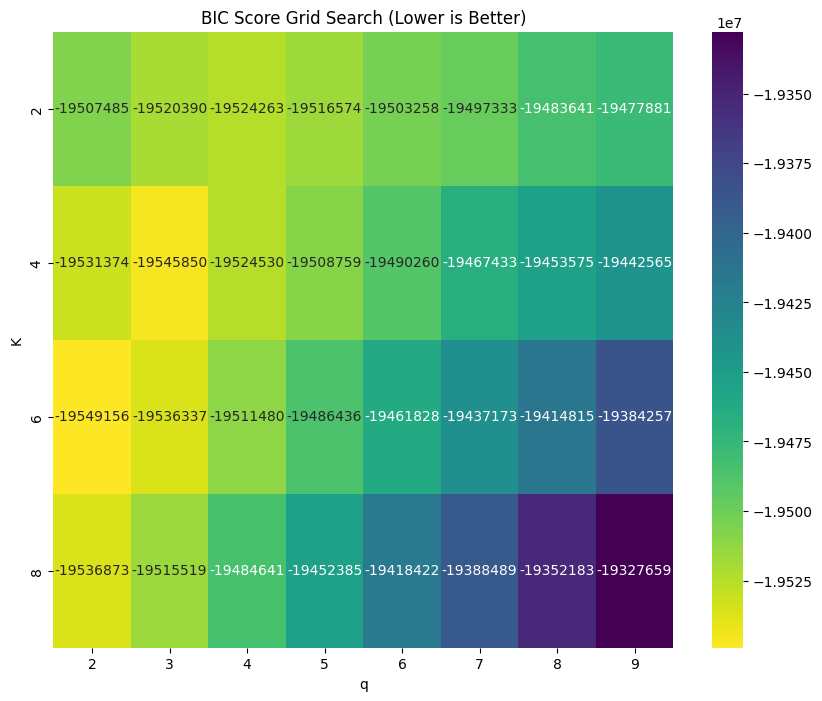

In [10]:
# Grid Configuration
k_range = range(2, 10, 2)
# Calculate ceiling and add safety buffer
q_ceiling = max(n_components_995 + 2, 5) 
q_range = range(2, q_ceiling + 1) 

print(f"Starting BIC Grid Search on {len(data_subset)} samples...")

subset_max = data_subset.max()
print(f"Original Max Value: {subset_max}")
X_scaled = data_subset / subset_max 

subset_mean = X_scaled.mean(dim=0)
X_processed = X_scaled - subset_mean

# Ensure float32
X_processed = X_processed.float()

print(f"Data Processed: Max={X_processed.max():.4f}, Mean (should be 0)={X_processed.mean():.4f}")

bic_scores = []
results_list = []

print(f"Starting BIC Grid Search on {len(data_subset)} samples...")

# The Grid Search Loop
for k in k_range:
    for q in q_range:
        # q cannot exceed the number of features (120) or, strictly speaking, 
        # q should be small enough that the model is identified. 
        if q >= 120: 
            continue
            
        try:
            model = MFA(n_components=k, n_features=360, n_factors=q, device=device)
            # Set parameters
            model.initialize_parameters(X_processed)
            # Fit
            model.fit(X_processed)

            # Calculate BIC
            score = model.bic(X_processed)

            bic_scores.append(score)
            
            results_list.append({'K': k, 'q': q, 'BIC': score})

            # Clean up memory if using GPU
            if device.type == 'cuda':
                torch.cuda.empty_cache()
            
        except Exception as e:
            print(f"Failed for K={k}, q={q}: {e}")

# Visualization
if len(results_list) > 0:
    results_df = pd.DataFrame(results_list)

    # Find optimal
    best_row = results_df.loc[results_df['BIC'].idxmin()]
    print("-" * 30)
    print(f"Best Model configuration: K={int(best_row['K'])}, q={int(best_row['q'])}")
    print("-" * 30)

    # Pivot for Heatmap
    bic_pivot = results_df.pivot(index="K", columns="q", values="BIC")

    plt.figure(figsize=(10, 8))
    sns.heatmap(bic_pivot, annot=True, fmt=".0f", cmap="viridis_r")
    
    plt.title("BIC Score Grid Search (Lower is Better)")
    plt.show()
else:
    print("No results to plot. Please ensure the MFA model class is implemented.")

K_optimal = int(best_row['K'])
q_optimal = int(best_row['q'])

### Retrain the model on the complete dataset 

In [ ]:
data_max = data.max()
print(f"Original Max Value: {data_max}")
X_scaled = data / data_max 

mean = X_scaled.mean(dim=0)
X_processed = X_scaled - mean

# Ensure float32
X_processed = X_processed.float()
print(f"Shape of X_processed: {X_processed.shape}")

#Parameters found above
K = K_optimal
q = q_optimal
model = MFA(n_components=K, n_features=360, n_factors=q, device=device)

model.initialize_parameters(X_processed)

# Fit
model.fit(X_processed)
# Calculate BIC
BIC_score = model.bic(X_processed)
# Clean up memory if using GPU
if device.type == 'cuda':
    torch.cuda.empty_cache()

# Save model


mfa_state = {
    # -- Model Parameters --
    # model.state_dict() automatically grabs log_pi, mu, Lambda, log_psi
    'model_state_dict': model.state_dict(), 
    
    # -- Hyperparameters (Required to re-initialize the class) --
    'hyperparameters': {
        'n_components': K,
        'n_features': 360, # or X_processed.shape[1]
        'n_factors': q
    },
    
    # -- Preprocessing Stats (CRITICAL for inference) --
    'preprocessing': {
        'data_max': data_max, # From your normalization step
        'mean': mean          # From your centering step
    },
    
    # -- Metadata --
    'metrics': {
        'bic': BIC_score,
        'final_ll': getattr(model, 'final_ll', None)
    }
}

# 2. Save to file
save_path = f'../models/mfa_k{K}_q{q}_{data_product}_spatial_info.pt'
torch.save(mfa_state, save_path)
print(f"MFA model saved to '{save_path}'")



Original Max Value: 402.1874084472656
Shape of X_processed: torch.Size([39996, 360])
Initializing centers with K-Means, and normalized data...
Initialization complete.
MFA model saved to 'models/mfa_k6_q2_l1b.pt'
